In [1]:
# Import dependencies
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# size of the image
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [3]:
# Load dataset using tensorflow
dataset = tf.keras.preprocessing.image_dataset_from_directory(
           'Potato',shuffle = True,
            image_size = (IMAGE_SIZE,IMAGE_SIZE),
            batch_size = BATCH_SIZE)

#let's see the dataset
class_names = dataset.class_names


Found 2152 files belonging to 3 classes.


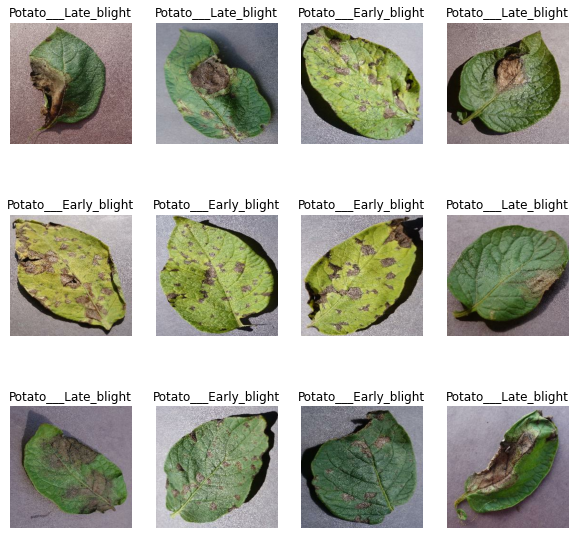

In [5]:
# Let's visualize the images
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [7]:
# Split the data into train validation and test dataset
train_size = 0.8 * len(dataset) # ~ 54
validation_size = 0.1 # ~ 6
test_size  = 0.1 # ~ 8

def train_test_split(ds,train_split = 0.8,val_split = 0.1,test_split= 0.1,shuffle=True,shuffle_size= 10000):
    ''' Return the train, validation and test datasets'''
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 5)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds   = ds.skip(train_size).take(val_size)
    test_ds  = ds.skip(train_size+val_size)
    return train_ds,val_ds,test_ds

In [8]:
#split the data into train test
train_ds,val_ds,test_ds = train_test_split(dataset)

In [9]:
# prefetch the data for optimization
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [10]:
# preprocessing - resizing and rescaling the images
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255) ])

# data agumentation - flip and rotate the images
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2) ])

### Convolutional Neural Network

In [12]:
# model with preprocessing and augmentation
inputshape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3)
n_classes = 3
model = models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=inputshape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])
# build model
model.build(inputshape)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [14]:
#complie the model
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [15]:
# fit model
EPOCHS = 30
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data = val_ds)

Epoch 1/30
54/54 [==============================] - 182s 3s/step - loss: 0.9208 - accuracy: 0.4677 - val_loss: 0.8355 - val_accuracy: 0.6094
Epoch 2/30
54/54 [==============================] - 135s 2s/step - loss: 0.7833 - accuracy: 0.6414 - val_loss: 0.6322 - val_accuracy: 0.7500
Epoch 3/30
54/54 [==============================] - 178s 3s/step - loss: 0.4575 - accuracy: 0.8128 - val_loss: 0.4289 - val_accuracy: 0.8177
Epoch 4/30
54/54 [==============================] - 121s 2s/step - loss: 0.2946 - accuracy: 0.8744 - val_loss: 0.3395 - val_accuracy: 0.8281
Epoch 5/30
54/54 [==============================] - 124s 2s/step - loss: 0.2066 - accuracy: 0.9190 - val_loss: 0.3359 - val_accuracy: 0.8750
Epoch 6/30
54/54 [==============================] - 113s 2s/step - loss: 0.1467 - accuracy: 0.9390 - val_loss: 0.1762 - val_accuracy: 0.9219
Epoch 7/30
54/54 [==============================] - 118s 2s/step - loss: 0.1726 - accuracy: 0.9319 - val_loss: 0.1107 - val_accuracy: 0.9635
Epoch 8/30
54

In [16]:
scores = model.evaluate(test_ds)
scores

8/8 [==============================] - 25s 335ms/step - loss: 0.0208 - accuracy: 0.9961


[0.020778028294444084, 0.99609375]

In [17]:
# get accuracy and loss from history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

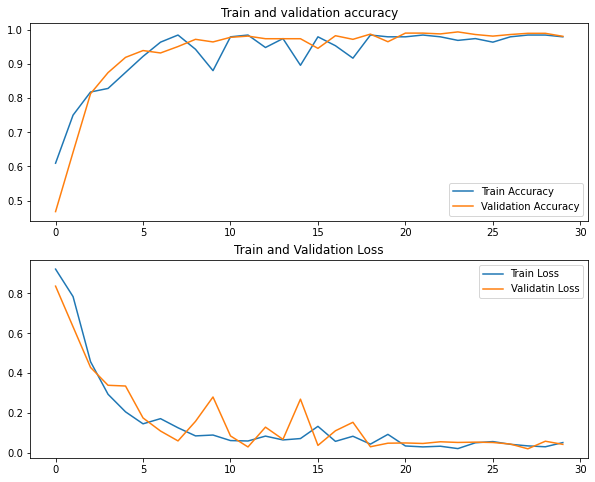

In [18]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(val_accuracy,label = 'Train Accuracy')
plt.plot(train_accuracy,label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Train and validation accuracy')
plt.subplot(2,1,2)
plt.plot(train_loss,label='Train Loss')
plt.plot(val_loss,label='Validatin Loss')
plt.title('Train and Validation Loss')
plt.legend(loc='upper right')
plt.show()

### Prediction for the test data

In [19]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) # create batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

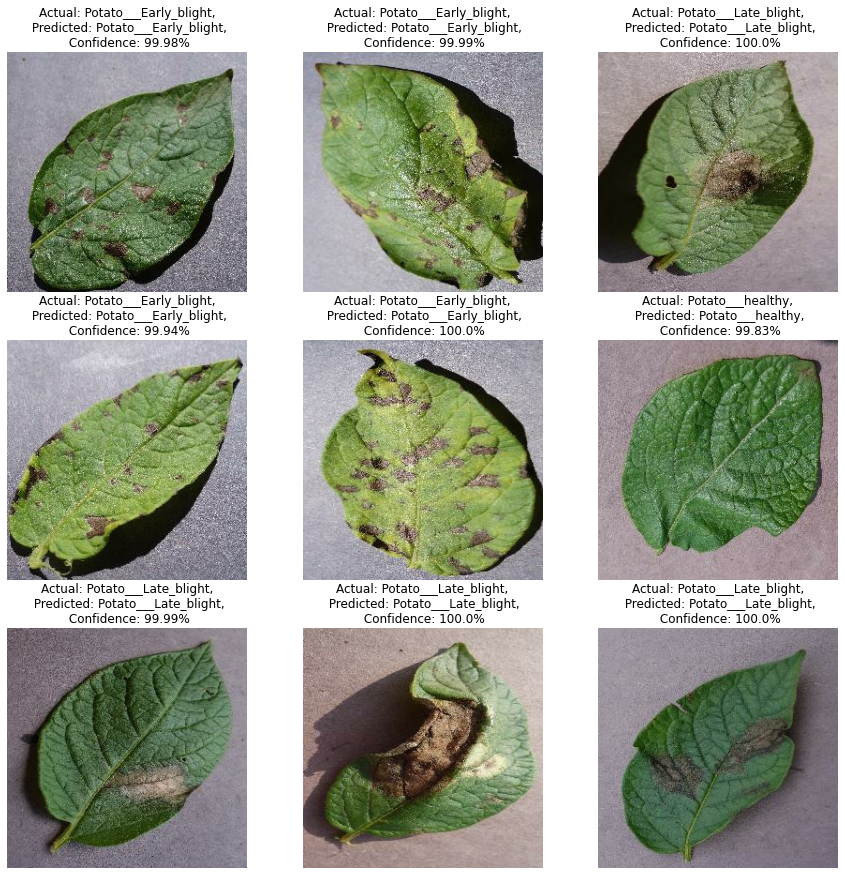

In [20]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class,confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f'Actual: { actual_class},\n Predicted: { predicted_class},\n Confidence: {confidence}%' )
        plt.axis('off')

In [ ]:
# save model 
model.save("potatoes.h5")